In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools
import copy
from joblib import Parallel, delayed
import multiprocessing
import pickle
import scipy.optimize as sco

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import predictions_ALS
from models.means import *
from models.medians import *
from models.helpers import *
from models.collaborative_filtering import *
from models.MF_SGD import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100
sc.setCheckpointDir('./checkpoint/')

In [2]:
train = load_csv()
train.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [3]:
models = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },
    'user_mean': {
        'compute_predictions': True,
        'function': user_mean,
        'params': {}
    },
    'movie_mean': {
        'compute_predictions': True,
        'function': movie_mean,
        'params': {}
    },
    'global_median': {
        'compute_predictions': True,
        'function': global_median,
        'params': {}    
    },  
    'user_median': {
        'compute_predictions': True,
        'function': user_median,
        'params': {}
    },
    'movie_median': {
        'compute_predictions': True,
        'function': movie_median,
        'params': {}
    }
}

models2 = {
    'movie_mean_deviation_user': {
        'compute_predictions': True,
        'function': movie_mean_deviation_user,
        'params': {}
    },
    'movie_median_deviation_user': {
        'compute_predictions': True,
        'function': movie_median_deviation_user,
        'params': {}
    }
}

models3 = {
    'als': {
        'compute_predictions': True,
        'function': predictions_ALS,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },
    'collab_filt': {
        'compute_predictions': True,
        'function': collaborative_filtering,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }
}

models4 = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },  
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    }   
}

models = dict(models, **models2)

models = dict(models, **models3)

In [4]:
def prepare_blending(data, k_folds, models):
    blending = CrossValidationBlending(data, k_folds)
    for key in models.keys():
        blending.add_model(models[key]['function'], key)
    return blending

def add_param_blending(blending, models):
    for key in models.keys():
        blending.add_params_for_model(key, models[key]['params'], compute_predictions=models[key]['compute_predictions'])
        
    return blending

def test_blending(blending, best_dict, models):
    dict_try = {}
    for key in models.keys():
        dict_try[key] = 0
        
    for key in models.keys():
        dict_test = dict_try.copy()
        dict_test[key] = 1
        rmse = blending.evaluate_blending(dict_test)
        print("RMSE for model %s: %.5f"%(key, rmse))
        
    print()
    rmse = blending.evaluate_blending(best_dict)
    print("Best blending: %s"%best_dict)
    print("RMSE best blending: %.5f"%rmse)
    
def prediction(train, blending, best_dict, output):
    test = pd.read_csv('../data/sampleSubmission.csv')
    test_prep = test
    test_prep['User'] = test_prep['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    test_prep['Movie'] = test_prep['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    test_prep['Rating'] = test_prep['Prediction']
    test_prep = test_prep.drop(['Prediction', 'Id'], axis=1)
    
    pred = blending.evaluate_blending_for_validation(best_dict, train, test_prep)
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5
        elif pred[i] < 1:
            pred[i] = 1
    
    test.Rating=pred
    test['Prediction']=test.Rating
    test = test.drop(['User', 'Movie', 'Rating'], axis=1)
    test.to_csv(output, index=False)
    
def eval_(x, blending, models):
    dict_try = {}
    for idx, key in enumerate(models.keys()):
        dict_try[key] = x[idx] 
        
    return blending.evaluate_blending(dict_try)

In [5]:
blending = prepare_blending(train, 10, models)

In [8]:
blending = add_param_blending(blending, models)

[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9906263182576142
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9902440865777487
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9905483897326202
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9899146200937358
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9906239211439712
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on trai

/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[GLOBAL

In [29]:
x0 = [ -7.36492006e+00,  -2.32789164e-01,   9.93738410e-01,
        -1.22879643e+00,  -8.78304096e+00,   1.36481862e+00,
         8.79145727e+00,   7.03119055e-03,   7.57838752e-02,
         5.35136273e+00,   1.80748824e+00]
res = sco.minimize(eval_, x0, method='Nelder-Mead', args=(blending, models), options={'maxiter':1000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.945663
         Iterations: 534
         Function evaluations: 794


In [30]:
res.x

array([ -7.36566420e+00,  -2.30498015e-01,   9.93318479e-01,
        -1.22831398e+00,  -8.78218141e+00,   1.36260396e+00,
         8.79071726e+00,   6.69534432e-03,   7.53953794e-02,
         5.35261216e+00,   1.80739164e+00])

In [32]:
dict_opt = {}
for idx, key in enumerate(models.keys()):
    dict_opt[key] = res.x[idx]
dict_opt

{'als': 0.99331847885718161,
 'collab_filt': 0.075395379441305782,
 'global_mean': 1.8073916422945944,
 'global_median': 5.3526121579824313,
 'mf_sgd': -0.23049801522419244,
 'movie_mean': 1.3626039613938992,
 'movie_mean_deviation_user': -1.2283139841518369,
 'movie_median': -8.7821814139990053,
 'movie_median_deviation_user': 8.7907172641516222,
 'user_mean': -7.3656641985213271,
 'user_median': 0.0066953443196113519}

In [33]:
test_blending(blending, dict_opt, models)

RMSE for model user_mean: 1.09465
RMSE for model mf_sgd: 0.99995
RMSE for model als: 0.98596
RMSE for model movie_mean_deviation_user: 0.99647
RMSE for model movie_median: 1.09943
RMSE for model movie_mean: 1.03039
RMSE for model movie_median_deviation_user: 1.05773
RMSE for model user_median: 1.15076
RMSE for model collab_filt: 1.02369
RMSE for model global_median: 1.12812
RMSE for model global_mean: 1.11906

Best blending: {'user_mean': -7.3656641985213271, 'global_median': 5.3526121579824313, 'mf_sgd': -0.23049801522419244, 'als': 0.99331847885718161, 'movie_mean_deviation_user': -1.2283139841518369, 'global_mean': 1.8073916422945944, 'movie_median': -8.7821814139990053, 'movie_mean': 1.3626039613938992, 'movie_median_deviation_user': 8.7907172641516222, 'user_median': 0.0066953443196113519, 'collab_filt': 0.075395379441305782}
RMSE best blending: 0.94566


In [34]:
prediction(train, blending, dict_opt, 'pred_blending.csv')

[USER_MEAN] applying
[USER_MEAN] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9908975630629756
[MF-SGD] Done
[ALS] applying
[ALS] done
[MOVIE_MEAN_DEVIATION_USER] applying
[MOVIE_MEAN_DEVIATION_USER] done
[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[MOVIE_MEDIAN] applying
[MOVIE_MEDIAN] done
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[USER_MEDIAN] applying
[USER_MEDIAN] done
[COLLABORATIVE FILTERING] applying


/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:61: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done


In [35]:
df = pd.read_csv('pred_blending.csv')
df.head()

,Id,Prediction
0,r37_c1,3.283915
1,r73_c1,3.151462
2,r156_c1,3.840964
3,r160_c1,3.389542
4,r248_c1,3.609437


In [36]:
pred = list(df.Prediction)

(array([  5.00000000e+01,   7.20000000e+01,   1.95000000e+02,
          4.90000000e+02,   1.17000000e+03,   2.50400000e+03,
          5.33100000e+03,   1.01250000e+04,   1.93160000e+04,
          3.43070000e+04,   5.79280000e+04,   8.90680000e+04,
          1.24472000e+05,   1.55533000e+05,   1.76275000e+05,
          1.72627000e+05,   1.45169000e+05,   1.00867000e+05,
          5.39720000e+04,   2.74810000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

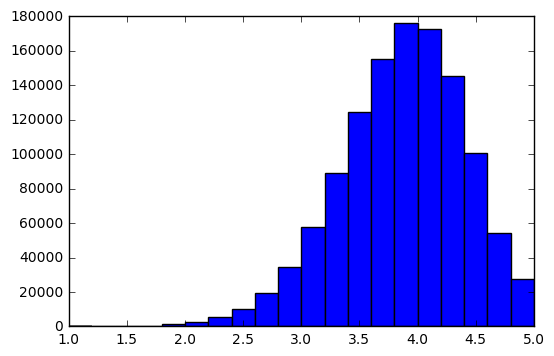

In [37]:
plt.hist(pred, bins=20)